# In Depth: Decision Trees & Random Forests
Random forests are an example of an *ensemble* method - a method that relies on aggregating the results of an ensemble of simpler estimators. Surprisingly, a majority vote among a number of estimators can end up being better than any of the individual estimators doing the voting.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Decision Trees
Random forests are an example of an ensemble learner built on decision trees. Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero in on the classification. For example, if you wanted to contruct a decision tree to figure out what animal you just came across is, your decision tree may look like this:

![decision tree](images/decisiontree.png)

The binary splitting makes this extremely efficient. In a well-constructed decision tree, each question will cut the number of options by approximately half, which quickly narrows the options even with a massive number of classes. The questions of decision trees generally take the form of axis-aligned splits in the data; each node in the tree splits the data into two groups using a cutoff value within one of the features.

#### Creating a decision tree

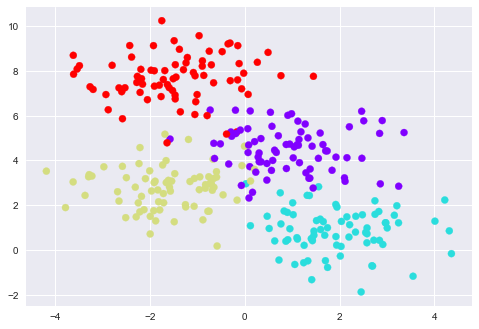

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='rainbow');

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it. Here is a look at the first four levels of a decision tree classifier for this data:

![decision tree levels](images/decisiontreelevels.png)

After the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch. At each level, every region is again split along one of the two features. Let's take a look at this using Scikit-Learn.

In [4]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [7]:
# Utility function to plot classifier

def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:,0], X[:,1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Create a color plot with results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.5, levels= np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim= (y.min(), y.max()), zorder=1)
    
    ax.set(xlim=xlim, ylim=ylim)

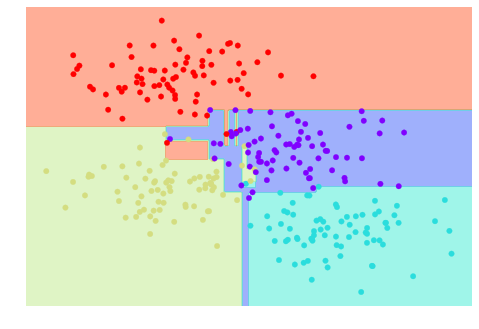

In [8]:
visualize_classifier(DecisionTreeClassifier(), X, y)

Notice as the depth increases, we tend to get very strangely shaped classification regions such as the tall skinny purple region sandwiched between yellow and blue regions. This is less a result of the true, intrinsic data distribution, and more of a result of the particular sampling or noise properties of the data. Even at 5 levels deep, the decision tree appears to be overfitting the data.

#### Decision trees and overfitting

Overfitting turns out to be a general property of decision trees as it is very easy to go deep into a tree and fit the details of the particular data rather than see the overall properties of the distributions they are drawn from. As one may expect, overfitting tends to happen in regions where the classification is less certain. This problem can be avoided by using multiple models trained on different subsets of the data. By using information from multiple trees, we can come up with a better result.

## Ensembles of Estimators: Random Forests

The notion that multiple overfitting estimators can be combined to reduce the effect of the overfitting is what underlies an ensemble method called ***bagging***. Bagging makes use of an ensemble of parallel estimators, each of which overfits the data, and averages the results to find a better classification. An ensemble of randomized decision trees is known as a *random forest*. Let's see it in Scikit-Learn:

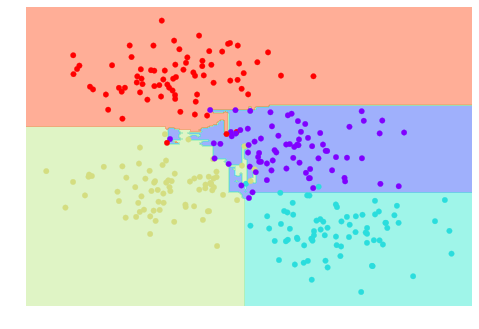

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In the above example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points. In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the `RandomForestClassifier` estimator, which takes care of all the randomization automatically. All you need to do is select the number of estimators, and it will very quickly fit the ensemble of trees.

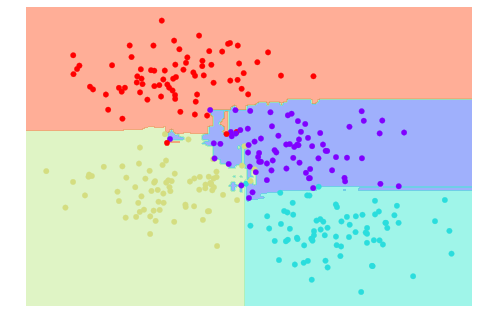

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

## Random Forest Regression

Above, we discussed random forests in the context of classification, but random forests can also be made to work in the case of regression. Here is an example:

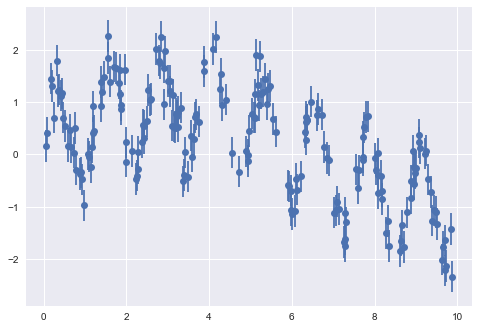

In [15]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))
    
    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

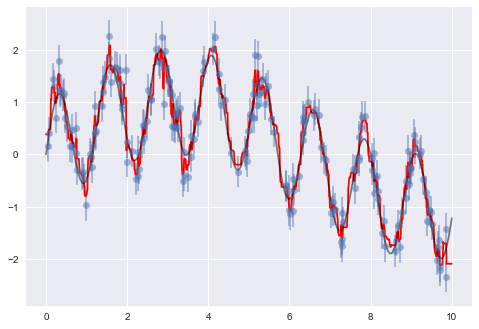

In [16]:
# Use random forest regressor to create a better fit
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r')
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown by the smooth curve, while the random forest model is shown by the jagged curve. The nonparametric random forest model is flexible enough to fit the multiperiod data without needing to specify a multiperiod model.

## Example: Random Forest for Classifying Digits

In [17]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

['images', 'data', 'target_names', 'DESCR', 'target']

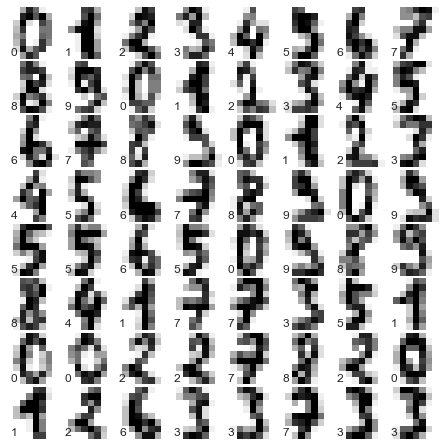

In [19]:
# visualize a few data points
# set up the figure
fig = plt.figure(figsize=(6,6)) # in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plt the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with target value
    ax.text(0, 7, str(digits.target[i]))

In [21]:
# classify using random forest
from sklearn.model_selection import train_test_split

In [22]:
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=0)

model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [23]:
from sklearn import metrics
print metrics.classification_report(ypred, ytest)

             precision    recall  f1-score   support

          0       1.00      0.97      0.99        38
          1       0.98      0.95      0.97        44
          2       0.95      1.00      0.98        42
          3       0.98      0.98      0.98        45
          4       0.97      1.00      0.99        37
          5       0.98      0.96      0.97        49
          6       1.00      1.00      1.00        52
          7       1.00      0.96      0.98        50
          8       0.94      0.98      0.96        46
          9       0.98      0.98      0.98        47

avg / total       0.98      0.98      0.98       450



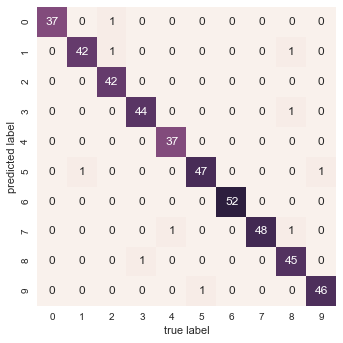

In [24]:
mat = metrics.confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Wow, a simple untuned random forest results in a very accurate classification of the handwritten digits!

## Random Forest Summary

Advantages of Random Forests:
 - Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
 - The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability.
 - The nonparametric model is extremely flexible, and can thus perform well on tasks that are underfit by other estimators.
 
Disadvantages:
 - Results are not easily interpreted. If you would like to draw conclusions about the meaning of the classification model, random forests may not be the best choice.